In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import numpy as np
import time
import cv2
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn 
import matplotlib.pyplot as plt
from collections import OrderedDict
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler
from torchvision.models import resnet50,vgg19
from PIL import Image
from typing import List

In [ ]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
train_data_path = "/content/drive/MyDrive/FYP2/Data/train"
test_data_path = "/content/drive/MyDrive/FYP2/Data/test"

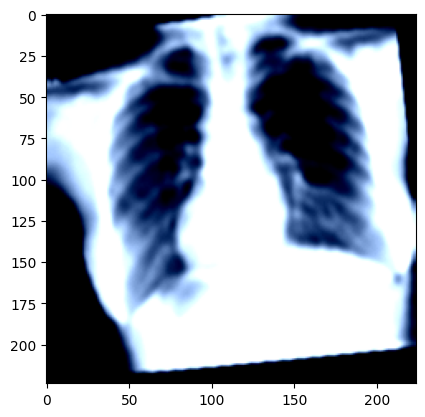

In [ ]:
n_epochs = 30
fc_layer = [1024, 512]
batch_size = 32
lr = 0.01
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(10),
                                       transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]),
])

cuda_kwargs_tr = {
    'num_workers' : 2,
    'pin_memory' : True,
    'batch_size' : batch_size,
    'shuffle' : True
}
cuda_kwargs_te = {
    'num_workers' : 2,
    'pin_memory' : True,
    'batch_size' : batch_size,
    'shuffle' : False
}
original_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=test_transforms) 

train_data_size = int(len(original_data) * 0.7)
valid_data_size = len(original_data) - train_data_size

train_data, valid_data = torch.utils.data.random_split(
    original_data, [train_data_size, valid_data_size], 
    generator=torch.Generator().manual_seed(72))
train_data_loader = torch.utils.data.DataLoader(train_data, **cuda_kwargs_tr)
valid_data_loader = torch.utils.data.DataLoader(valid_data, **cuda_kwargs_tr)
test_data_loader  = torch.utils.data.DataLoader(test_data, **cuda_kwargs_te)
imgs, _ = next(iter(train_data_loader))
plt.imshow(imgs[0].permute(1, 2, 0))

edit here

In [ ]:
print("Train set:\n---------------------------------------------------")
BACTERIAL_PNEUMONIA_TRAIN = len(os.listdir(os.path.join(train_data_path, 'BACTERIALPNEUMONIA')))
COVID19_TRAIN= len(os.listdir(os.path.join(train_data_path, 'COVID19')))
LUNGINFECTION_TRAIN=len(os.listdir(os.path.join(train_data_path, 'LUNGINFECTION')))
NORMAL_TRAIN= len(os.listdir(os.path.join(train_data_path, 'NORMAL')))
VIRAL_PNEUMONIA_TRAIN = len(os.listdir(os.path.join(train_data_path, 'VIRALPNEUMONIA')))
print(f"BACTERIAL_PNEUMONIA_TRAIN={BACTERIAL_PNEUMONIA_TRAIN}",
      f"\nCOVID19_TRAIN={COVID19_TRAIN}",
      f"\nLUNGINFECTION_TRAIN={LUNGINFECTION_TRAIN}",
      f"\nNORMAL_TRAIN={NORMAL_TRAIN}",
      f"\nVIRAL_PNEUMONIA_TRAIN={VIRAL_PNEUMONIA_TRAIN}")

total_train = BACTERIAL_PNEUMONIA_TRAIN+COVID19_TRAIN+LUNGINFECTION_TRAIN+NORMAL_TRAIN+VIRAL_PNEUMONIA_TRAIN
print("Train set total: ", total_train, "-----------------------------")

print("\nTest set:\n----------------------------------------------------")
BACTERIAL_PNEUMONIA_TEST = len(os.listdir(os.path.join(test_data_path, 'BACTERIALPNEUMONIA')))
COVID19_TEST= len(os.listdir(os.path.join(test_data_path, 'COVID19')))
LUNGINFECTION_TEST=len(os.listdir(os.path.join(test_data_path, 'LUNGINFECTION')))
NORMAL_TEST= len(os.listdir(os.path.join(test_data_path, 'NORMAL')))
VIRAL_PNEUMONIA_TEST = len(os.listdir(os.path.join(test_data_path, 'VIRALPNEUMONIA')))
print(f"BACTERIAL_PNEUMONIA_TEST={BACTERIAL_PNEUMONIA_TEST}",
      f"\nCOVID19_TEST={COVID19_TEST}",
      f"\nLUNGINFECTION_TEST={LUNGINFECTION_TEST}",
      f"\nNORMAL_TEST={NORMAL_TEST}",
      f"\nVIRAL_PNEUMONIA_TEST={VIRAL_PNEUMONIA_TEST}")

total_test = BACTERIAL_PNEUMONIA_TEST+COVID19_TEST+LUNGINFECTION_TEST+NORMAL_TEST+VIRAL_PNEUMONIA_TEST
print("Test set total: ",total_test, "----------------------------------")

print("\nTotal number of images:", total_test+total_train,"----------------------------")

Train set:
---------------------------------------------------
BACTERIAL_PNEUMONIA_TRAIN=2541 
COVID19_TRAIN=3255 
LUNGINFECTION_TRAIN=5411 
NORMAL_TRAIN=9172 
VIRAL_PNEUMONIA_TRAIN=1211
Train set total:  21590 -----------------------------

Test set:
----------------------------------------------------
BACTERIAL_PNEUMONIA_TEST=242 
COVID19_TEST=361 
LUNGINFECTION_TEST=601 
NORMAL_TEST=1020 
VIRAL_PNEUMONIA_TEST=134
Test set total:  2358 ----------------------------------

Total number of images: 23948 ----------------------------


In [ ]:
class VGG19Modelv2():
    def __init__(self,
                 fc_layer:List[int],
                 pretrained: bool, lr: int,
                 train_data_loader,
                 valid_data_loader,
                 test_data_loader,
                 device):
        self.model = vgg19(pretrained)
        
        self.classifier = nn.Sequential(OrderedDict([
                            ('cnn_to_fc', nn.Linear(2048, fc_layer[0])),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout()),
                            ('fc1', nn.Linear(fc_layer[0], fc_layer[1])),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout()),
                            ('fc2', nn.Linear(fc_layer[1], 5)) #edit here
                        ]))
        
        self.patient = 5
        
        self.device = device
        self.lr = lr
        self.train_data_loader =train_data_loader
        self.valid_data_loader = valid_data_loader      
        self.test_data_loader = test_data_loader
        
        self.train_loss_list = []
        self.valid_loss_list = []
        self.train_acc_list = []
        self.valid_acc_list = []
        self.cm = np.array([[0, 0],
                            [0, 0]])
        self.test_acc = 0
        self.test_time = 0
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda = lambda epoch:self.scheduler(epoch))
        self.lr_list = []
        
        self.loss_list = {'train': [], 'valid': []}
        self.acc_list = {'train':[], 'valid': []}
                
#         for param in self.model.parameters():
#             param.requires_grad = False 
        self.model.fc = self.classifier
        
        self.model.to(self.device)
        
    @staticmethod
    def scheduler(epoch):
#         if epoch < n_epochs/5:
#             epoch_delta =  n_epochs/5 
#             m = (1e-2 - 1e-4)/epoch_delta
#             return 0.01 - m * (epoch-1)
#         else:
#             new_epoch = epoch - n_epochs/5
#             epoch_delta =  n_epochs/5 * 4
#             m = (1e-2 - 1e-6)/epoch_delta
#             return 0.01 - m * new_epoch
        return 0.01 - (1e-2-1e-6)/n_epochs * (epoch-1)

    @staticmethod
    def ROC_curve(output, labels):
        output = torch.from_numpy(output)
        o = torch.nn.Softmax(dim=1)
        p = o(output).data.cpu().numpy()
        l = np.copy(labels)

        for i in p:
            i[0] += i[2]

        l[l == 2] = 0

        P = l[l == 0].shape[0]
        L = l[l == 1].shape[0]
        print(P, L)
        y_unit=1/P
        X_unit=1/L

        data = []
        for i in range(p.shape[0]):
            data.append([p[i][0], l[i]])
        data.sort(reverse=True)
        X=[]
        y=[]
        current_X=0
        current_y=0
        for row in data:
            if row[1] == 0:
                current_y+=y_unit
            else:
                current_X+=X_unit
            X.append(current_X)
            y.append(current_y)

        X=np.array(X)        
        y=np.array(y)    

        plt.figure(figsize=[12,6])
        plt.title('Receiver Operating Characteristic')
        plt.plot(X, y, color = 'orange')
        plt.legend()
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
   
    @staticmethod
    def show_grid(loss, acc): 
    
        plt.figure(figsize=[12,6])
        plt.subplot(1,2,1)

        plt.plot(loss['train'], label='train_loss')
        plt.plot(loss['valid'], label='val_loss')   
        plt.xlabel('epochs')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(acc['train'], label='train_acc')
        plt.plot(acc['valid'], label='val_acc')   
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
    
    def early_stopping(self, current_loss_delta, val_acc):
        last_loss_delta = 0
        if current_loss_delta > last_loss_delta:
            self.patient -= 1
        if self.patient <= 0 and val_acc > 0.97:
            return True
        return False
    
    def train(self, epoch):
        if epoch == n_epochs/5 + 1:
            for param in self.model.parameters():
                param.requires_grad = True
    
        self.model.train()
        
        epoch_loss=0 
        correct=0 
        total=0
        
        for inputs, labels in self.train_data_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad() # zeroed grads
            outputs = self.model(inputs) # forward pass
            loss = self.criterion(outputs, labels) # softmax + cross entropy
            loss.backward() # back pass
            self.optimizer.step() # updated params
            epoch_loss += loss.item() # train loss
            _, pred = torch.max(outputs, dim=1)
            correct += (pred.cpu() == labels.cpu()).sum().item()
            total += labels.shape[0]
        self.lr_scheduler.step()
        print(epoch, self.lr_scheduler.get_last_lr()[0])
        self.lr_list.append(self.lr_scheduler.get_last_lr()[0])
        train_acc = correct / total
        train_loss = epoch_loss/len(labels)
        
        self.loss_list['train'].append(round(train_loss, 4)) 
        self.acc_list['train'].append(round(train_acc, 4))
        return train_loss, train_acc
        
    def validation(self):
        self.model.eval()
        
        a=0
        pred_val=0
        correct_val=0
        total_val=0
        
        with torch.no_grad():
            for inp_val, lab_val in self.valid_data_loader:
                inp_val = inp_val.to(self.device)
                lab_val = lab_val.to(self.device)
                out_val = self.model(inp_val)
                loss_val = self.criterion(out_val, lab_val)
                a += loss_val.item()
                _, pred_val = torch.max(out_val, dim=1)
                correct_val += (pred_val.cpu()==lab_val.cpu()).sum().item()    
                total_val += lab_val.shape[0]
            acc_val = correct_val / total_val
            loss_val = a/len(lab_val)
            
            self.loss_list['valid'].append(round(loss_val, 4))
            self.acc_list['valid'].append(round(acc_val, 4))
        return loss_val, acc_val
    
    def test(self):
        re_output = np.array([[]])
        re_labels = np.array([])
        correct = 0
        total = 0
        start_time = time.time()
        with torch.no_grad():
            for images, labels in self.test_data_loader:
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                p = np.copy(predicted.cpu())
                l = np.copy(labels.cpu())
                p[p == 2] = 0
                l[l == 2] = 0
                print(p)
                print(l)
                self.cm[0][0] += (l+p == 2).sum().item()
                self.cm[1][0] += (p-l == 1).sum().item() 
                self.cm[0][1] += (l-p == 1).sum().item()
                self.cm[1][1] += (l+p == 0).sum().item()
                try:
                    re_output = np.concatenate((re_output, outputs.data.cpu())) 
                    re_labels = np.concatenate((re_labels, labels.data.cpu())) 
                except:
                    re_output, re_labels = outputs.data.cpu(), labels.data.cpu()
        self.test_acc = round(float(correct)/float(total)*100, 4)
        end_time = time.time()
        self.test_time = end_time - start_time
        print(f"Accuracy of the network on the test images: {self.test_acc:.2f}")
        return re_output, re_labels
    
    def save(self, file_path):
        torch.save(self.model, file_path)

In [ ]:
#edit here
model = VGG19Modelv2(fc_layer, True, lr, train_data_loader, valid_data_loader, test_data_loader, device)
n_epochs=30
if __name__ == '__main__':
    start_time = time.time()
    for epoch in range(1, n_epochs+1):
        epoch_time = time.time()
        print("Epoch {} / {}".format(epoch, n_epochs))
        train_loss, train_acc = model.train(epoch)
        loss_val, acc_val = model.validation()
        epoch_end_time = time.time()
        print("Duration: {:.0f}s, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}"
              .format(epoch_end_time-epoch_time, train_loss, train_acc, loss_val, acc_val))
        flag = model.early_stopping(loss_val - train_loss, acc_val)
        if flag:
            break
    end_time = time.time()
    print("Total Time:{:.0f}s".format(end_time-start_time))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 245MB/s]


Epoch 1 / 30
1 0.0001
Duration: 6535s, Train Loss: 36.1165, Train Acc: 0.7787, Val Loss: 6.3961, Val Acc: 0.8319
Epoch 2 / 30
2 9.6667e-05
Duration: 336s, Train Loss: 22.2778, Train Acc: 0.8568, Val Loss: 6.6120, Val Acc: 0.8197
Epoch 3 / 30
3 9.333400000000001e-05
Duration: 343s, Train Loss: 18.5278, Train Acc: 0.8812, Val Loss: 4.1471, Val Acc: 0.8980
Epoch 4 / 30
4 9.000100000000001e-05
Duration: 344s, Train Loss: 16.8144, Train Acc: 0.8921, Val Loss: 4.3524, Val Acc: 0.8913
Epoch 5 / 30
5 8.6668e-05
Duration: 343s, Train Loss: 15.6884, Train Acc: 0.8990, Val Loss: 4.0385, Val Acc: 0.8966
Epoch 6 / 30
6 8.333500000000001e-05
Duration: 341s, Train Loss: 15.5095, Train Acc: 0.8995, Val Loss: 4.4240, Val Acc: 0.8861
Epoch 7 / 30
7 8.0002e-05
Duration: 340s, Train Loss: 13.7170, Train Acc: 0.9112, Val Loss: 3.7157, Val Acc: 0.9048
Epoch 8 / 30
8 7.666900000000001e-05
Duration: 341s, Train Loss: 13.1500, Train Acc: 0.9141, Val Loss: 3.9596, Val Acc: 0.8977
Epoch 9 / 30
9 7.3336e-05
Durat

In [ ]:
outputs, labels = model.test()
cm = model.cm

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 3 1 1]
[0 0 0 0 0

# **Confusion Matrix**

In [ ]:
actual=[]
pred=[]
#test_data_loader.to(0)
#model.model.to('cuda')
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        #inputs = torch.unsqueeze(inputs, 0)
        #labels = labels.to(device)
        #model2.optimizer.zero_grad() # zeroed grads
        outputs = model.model(inputs) # forward pass
        _, predicted = torch.max(outputs.data, 1)
        #print(labels)        
        #_, ac = torch.max(labels, 1)

        actual.append(labels)
        pred.append(predicted)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[239   0   0   1   2]
 [  0 336   8  16   1]
 [  0   3 518  80   0]
 [ 19   3   1 941  56]
 [ 65   0   0   2  67]]


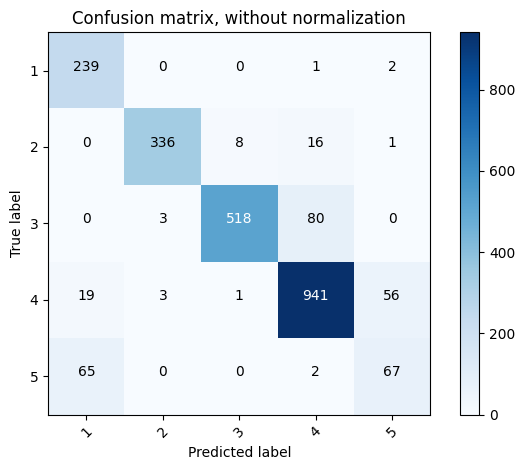

In [ ]:
p=[]
for i in range(len(pred)):
  for j in range(len(pred[i].cpu().numpy())):
    p.append(pred[i].cpu().numpy()[j])
a=[]
for i in range(len(actual)):
  for j in range(len(actual[i].cpu().numpy())):
    a.append(actual[i].cpu().numpy()[j])
    
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(a,p)    

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'], #edit here
                      title='Confusion matrix, without normalization')

# **ROC curve (one vs rest)**

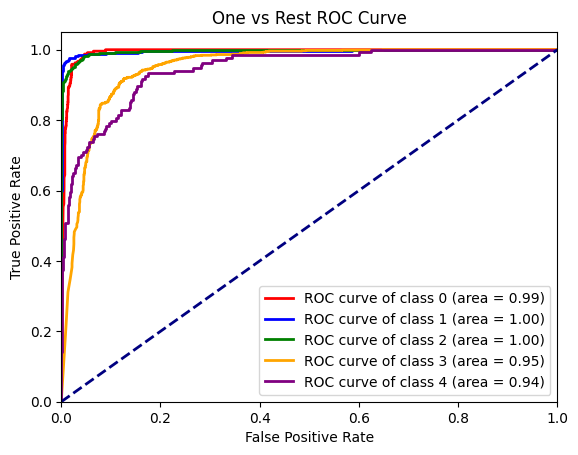

In [ ]:
from sklearn.metrics import roc_curve, auc

#plot roc one vs rest curve
with torch.no_grad():
    actual = []
    labels = []
    for inputs, targets in test_data_loader:
        inputs = inputs.to(device)
        outputs = model.model(inputs)
        actual.append(torch.sigmoid(outputs).cpu().numpy())
        labels.append(targets.cpu().numpy())
    actual = np.concatenate(actual, axis=0)
    labels = np.concatenate(labels, axis=0)

# Compute the ROC curve and AUC for each class
n_classes = len(test_data_loader.dataset.classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels == i, actual[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One vs Rest ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **# MODEL INFERENCE FOR SINGLE IMAGE**

In [ ]:
test_transforms2 = transforms.Compose([    
    transforms.ToPILImage(),
    transforms.Resize((320, 320)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale image
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


cuda_kwargs_te2 = {
    'num_workers' : 2,
    'pin_memory' : True,
    'batch_size' : batch_size,
    'shuffle' : False
}
#test_data_path2
import matplotlib.image as mpimg
#img = mpimg.imread('/content/drive/MyDrive/FYP/XRAY_Dataset/Data/test/COVID19/COVID19(460).jpg')
from torchvision.io import read_image
img = read_image('/content/drive/MyDrive/FYP2/Data/test/BACTERIALPNEUMONIA/person101_bacteria_486.jpeg') #change to use test dir
print(type(img))
print(len(img))
# img = img.astype(float)
# img = img.float()
#print(img)
img = test_transforms2(img)
#test_data2 = torchvision.datasets.Image(root=test_data_path2,transform=test_transforms2) 


test_data_loader2  = torch.utils.data.DataLoader(img, **cuda_kwargs_te2)
imgs = next(iter(test_data_loader2))
##plt.imshow(imgs[0].permute(1, 2, 0))

<class 'torch.Tensor'>
1


In [ ]:
import torch.nn.functional as F

# assume `outputs` is your model's output tensor
probabilities = F.softmax(outputs, dim=1)
class_labels = ["bacterial pneumonia", "COVID-19","lung infection", "normal", "viral pneumonia"]

K = 5  # number of top classes to show
top_probs, top_classes = torch.topk(probabilities, K)

for i in range(K):
    class_idx = top_classes[0][i].item()
    class_prob = top_probs[0][i].item()
    class_name = class_labels[class_idx]
    print(f"{class_name}: {class_prob*100:.4f}")

bacterial pneumonia: 99.2758
viral pneumonia: 0.7188
COVID-19: 0.0044
lung infection: 0.0008
normal: 0.0001


In [ ]:
for inputs in test_data_loader2:
    inputs = inputs.to(device)
    inputs = torch.unsqueeze(inputs, 0)
    #labels = labels.to(device)
    model.optimizer.zero_grad() # zeroed grads
    outputs = model.model(inputs) # forward pass
    _, predicted = torch.max(outputs.data, 1)

In [ ]:
predicted

tensor([0], device='cuda:0')

edit here to show lung infection

In [ ]:
if predicted[0]==0:
  print("Bacterial Pneumonia")
if predicted[0]==1:
  print("Covid-19")  
if predicted[0]==2:
  print("Lung infection")
if predicted[0]==3:
  print("Normal") 
if predicted[0]==4:
  print("Viral Pneumonia") 

Bacterial Pneumonia


In [ ]:
import joblib

# assume you have a ResNet model called `resnet_model`
joblib.dump(VGG19Modelv2, 'VGG19Modelv2prob.joblib')

['VGG19Modelv2prob.joblib']

In [ ]:
# import joblib
# #Save the model to a joblib file
# joblib.dump(VGG19Modelv1, 'vgg19_model_v2.joblib') #edit